<a href="https://colab.research.google.com/github/mehrshad-sdtn/BSc-Thesis-Project/blob/master/notebooks/pca_data_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from keras import backend as K
import logging
import random

In [3]:
base_dir = '/content/drive/MyDrive'
data_dir = os.path.join(base_dir, 'BSc_Project', 'out')
dataset_path = os.path.join(data_dir, 'A')

In [4]:
models_path = os.path.join(base_dir, 'BSc_Project', 'models')

**Loading the image dataset**

In [5]:
height = 224
width = 224

def image_read(image_dir):
  src = cv2.imread(image_dir)
  src_rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
  image = cv2.resize(src_rgb, (width, height))
  image = image.astype('float32') / 255.
  return image



def images_from_directory(dataset_path, cat):
  image_list = []
  images_path = os.path.join(dataset_path, cat)
  images_names = [os.path.join(images_path, name) for name in os.listdir(images_path)]
  for image_dir in images_names:
    image = image_read(image_dir)
    image_list.append(image)
  return image_list


def train_validation_split(X, ratio=0.2):
  length = int(ratio * X.shape[0])
  return X[length:], X[:length]


###Main data

In [6]:
##### Loading and Preprocessing main dataset

norm_list = images_from_directory(dataset_path, 'norm')
sch_list  = images_from_directory(dataset_path, 'sch')

all_data = []
all_data.extend(norm_list)
all_data.extend(sch_list)

print(len(all_data))

X_main = np.array(all_data)

948


###VAE data

In [7]:
##### Loading and Preprocessing VAE-generated dataset

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def load_autoencoder(names):
  """
  names is a dictionary containing 'decoder' and 'encoder' names
  """
  encoder = keras.models.load_model(os.path.join(models_path, names['encoder']), custom_objects={'Sampling':Sampling}) 
  decoder = keras.models.load_model(os.path.join(models_path, names['decoder']))
  return encoder, decoder 


tf.random.set_seed(42)
np.random.seed(42)

latent_dim = 512


def encoder(inputs):
  # (224, 224, 3)

  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs) 
  # (112, 112, 32)

  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(x)
  # (7, 7, 512)

  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(1024, activation="relu")(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  v_encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
  v_encoder.summary()
  return v_encoder, z_log_var, z_mean


def decoder():
  latent_inputs = keras.Input(shape=(latent_dim,))

  x = layers.Dense(1024, activation="relu")(latent_inputs)
  x = layers.Dense(1024, activation="relu")(x)
  x = layers.Dense(7*7*512, activation="relu")(x)
  x = layers.Reshape((7, 7, 512))(x)

  x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
  # (14, 14, 256)

  x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
  # (28, 28, 128)

  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  # (56, 56, 64)

  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  # (112, 112, 32)

  decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid",  strides=2, padding="same")(x)
  v_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  v_decoder.summary()
  return v_decoder


inputs = keras.layers.Input(shape=(224, 224, 3))
norm_encoder, norm_codings_log_var, norm_codings_mean = encoder(inputs)
norm_decoder = decoder()
_, _, norm_codings = norm_encoder(inputs)
norm_reconstructions = norm_decoder(norm_codings)
norm_vae = keras.models.Model(inputs=[inputs], outputs=[norm_reconstructions])

latent_loss = -0.5 * K.sum(1 + norm_codings_log_var - K.exp(norm_codings_log_var) - K.square(norm_codings_mean), axis=-1)


inputs = keras.layers.Input(shape=(224, 224, 3))
sch_encoder, sch_codings_log_var, sch_codings_mean = encoder(inputs)
sch_decoder = decoder()
_, _, sch_codings = sch_encoder(inputs)
sch_reconstructions = sch_decoder(sch_codings)
sch_vae = keras.models.Model(inputs=[inputs], outputs=[sch_reconstructions])

sch_latent_loss = -0.5 * K.sum(1 + sch_codings_log_var - K.exp(sch_codings_log_var) - K.square(sch_codings_mean), axis=-1)


#### load ####
def load_autoencoder(names):
  """
  names is a dictionary containing 'decoder' and 'encoder' names
  """
  encoder = keras.models.load_model(os.path.join(models_path, names['encoder']), custom_objects={'Sampling':Sampling}) 
  decoder = keras.models.load_model(os.path.join(models_path, names['decoder']))
  return encoder, decoder 



norm_encoder, norm_decoder = load_autoencoder({'encoder': 'norm_encoder_v2.h5', 'decoder': 'norm_decoder_v2.h5'})
sch_encoder, sch_decoder = load_autoencoder({'encoder': 'sch_encoder_v2.h5', 'decoder': 'sch_decoder_v2.h5'})

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 56, 56, 64)   18496       ['conv2d[0][0]']                 
                                                                                            

In [8]:
def generate_vae_data(decoder):
  codings = tf.random.normal(shape=[1, latent_dim])
  images = decoder(codings).numpy()
  return np.squeeze(images)

print(generate_vae_data(norm_decoder).shape)

count = 450
vae_sch = [generate_vae_data(sch_decoder) for i in range(0, count)]
vae_norm = [generate_vae_data(norm_decoder) for i in range(0, count)]
vae_dataset = []
vae_dataset.extend(vae_sch)
vae_dataset.extend(vae_norm)

print(len(vae_dataset))

X_vae = np.array(vae_dataset)

(224, 224, 3)
900


In [9]:
X_vae.shape, X_main.shape

((900, 224, 224, 3), (948, 224, 224, 3))

###Autoencoder For PCA

In [10]:
tf.random.set_seed(42)
np.random.seed(42)


def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

latent_size = 128

def encoder():
  return keras.models.Sequential([ 
      keras.layers.Conv2D(32, 3, activation="relu", padding="same", input_shape=[224, 224, 3]),
      keras.layers.MaxPool2D(pool_size=2),
      # 112, 112, 32

      keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
      keras.layers.MaxPool2D(pool_size=2),
      # 56, 56, 64

      keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
      keras.layers.MaxPool2D(pool_size=2),
      # 28, 28, 128

      keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
      keras.layers.MaxPool2D(pool_size=2),
      # 14, 14, 256

      keras.layers.Flatten(),
      keras.layers.Dense(1024, activation="relu"),
      keras.layers.Dense(latent_size, activation="relu"),
  ])


def decoder(): 
  return keras.models.Sequential([
      keras.layers.Dense(1024, activation="relu", input_shape=[latent_size]),
      keras.layers.Dense(14*14*256, activation="relu"),
      keras.layers.Reshape((14, 14, 256)),

      keras.layers.Conv2DTranspose(128, 3, activation="relu", padding="same"),
      keras.layers.UpSampling2D((2, 2)),
      # 28, 28, 128

      keras.layers.Conv2DTranspose(64, 3, activation="relu", padding="same"),
      keras.layers.UpSampling2D((2, 2)),
      # 56, 56, 64

      keras.layers.Conv2DTranspose(32, 3, activation="relu", padding="same"),
      keras.layers.UpSampling2D((2, 2)),
      # 112, 112, 32
      keras.layers.Conv2DTranspose(3, 3, activation="relu", strides=2, padding="same")
  ])


In [18]:
main_enc, main_dec = encoder(), decoder()
main_ae = keras.models.Sequential([main_enc, main_dec])
main_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=[rounded_accuracy])

history = main_ae.fit(X_main, X_main, epochs=140, validation_split=0.2, batch_size=64)

Epoch 1/140
12/12 [==============================] - 8s 453ms/step - loss: 1.8881 - rounded_accuracy: 0.5315 - val_loss: 0.7695 - val_rounded_accuracy: 0.5850
Epoch 2/140
12/12 [==============================] - 3s 221ms/step - loss: 0.7769 - rounded_accuracy: 0.5535 - val_loss: 0.7468 - val_rounded_accuracy: 0.6184
Epoch 3/140
12/12 [==============================] - 3s 220ms/step - loss: 0.7147 - rounded_accuracy: 0.6220 - val_loss: 0.6909 - val_rounded_accuracy: 0.6902
Epoch 4/140
12/12 [==============================] - 3s 221ms/step - loss: 0.6740 - rounded_accuracy: 0.6655 - val_loss: 0.6627 - val_rounded_accuracy: 0.6649
Epoch 5/140
12/12 [==============================] - 3s 220ms/step - loss: 0.6525 - rounded_accuracy: 0.6792 - val_loss: 0.6417 - val_rounded_accuracy: 0.6722
Epoch 6/140
12/12 [==============================] - 3s 221ms/step - loss: 0.6344 - rounded_accuracy: 0.6925 - val_loss: 0.6276 - val_rounded_accuracy: 0.7287
Epoch 7/140
12/12 [===========================

In [19]:
vae_enc, vae_dec = encoder(), decoder()
vae_ae = keras.models.Sequential([vae_enc, vae_dec])
vae_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=[rounded_accuracy])

history = vae_ae.fit(X_vae, X_vae, epochs=140, validation_split=0.2, batch_size=64)

Epoch 1/140
12/12 [==============================] - 5s 356ms/step - loss: 1.6370 - rounded_accuracy: 0.4649 - val_loss: 0.9397 - val_rounded_accuracy: 0.5796
Epoch 2/140
12/12 [==============================] - 3s 214ms/step - loss: 0.9083 - rounded_accuracy: 0.6647 - val_loss: 0.8870 - val_rounded_accuracy: 0.7072
Epoch 3/140
12/12 [==============================] - 3s 216ms/step - loss: 0.8828 - rounded_accuracy: 0.6693 - val_loss: 0.8733 - val_rounded_accuracy: 0.6756
Epoch 4/140
12/12 [==============================] - 3s 215ms/step - loss: 0.8708 - rounded_accuracy: 0.7179 - val_loss: 0.8650 - val_rounded_accuracy: 0.7305
Epoch 5/140
12/12 [==============================] - 3s 214ms/step - loss: 0.8639 - rounded_accuracy: 0.7252 - val_loss: 0.8600 - val_rounded_accuracy: 0.7513
Epoch 6/140
12/12 [==============================] - 3s 216ms/step - loss: 0.8600 - rounded_accuracy: 0.7518 - val_loss: 0.8572 - val_rounded_accuracy: 0.7610
Epoch 7/140
12/12 [===========================

In [20]:
vae_enc.save(os.path.join(models_path, 'pca_vae_enc.h5'))
vae_dec.save(os.path.join(models_path, 'pca_vae_dec.h5'))

main_enc.save(os.path.join(models_path, 'pca_main_enc.h5'))
main_dec.save(os.path.join(models_path, 'pca_main_dec.h5'))

In [11]:
main_enc = keras.models.load_model(os.path.join(models_path, 'pca_main_enc.h5')) 
vae_enc = keras.models.load_model(os.path.join(models_path, 'pca_vae_enc.h5'))

main_dec = keras.models.load_model(os.path.join(models_path, 'pca_main_dec.h5')) 
vae_dec = keras.models.load_model(os.path.join(models_path, 'pca_vae_dec.h5'))

1/1 [==============================] - 0s 408ms/step


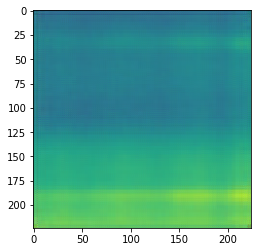

In [21]:
i = 0
recons = np.squeeze(main_ae.predict(X_main[i:i+1]))
plt.imshow(recons)
plt.show()

1/1 [==============================] - 0s 162ms/step


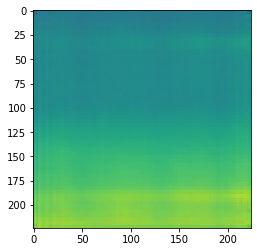

In [22]:
i = 0
recons = np.squeeze(vae_ae.predict(X_vae[i:i+1]))
plt.imshow(recons)
plt.show()

In [12]:
from sklearn.manifold import TSNE

X_main_compressed = main_enc.predict(X_main)
X_vae_compressed = vae_enc.predict(X_vae)

29/29 [==============================] - 1s 24ms/step


In [26]:
X_main_compressed.shape, X_vae_compressed.shape

((948, 128), (900, 128))

In [13]:
tsne = TSNE()
X_main_2D = tsne.fit_transform(X_main_compressed)
X_vae_2D = tsne.fit_transform(X_vae_compressed)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [31]:
X_main_2D.shape, X_vae_2D.shape

((948, 2), (900, 2))

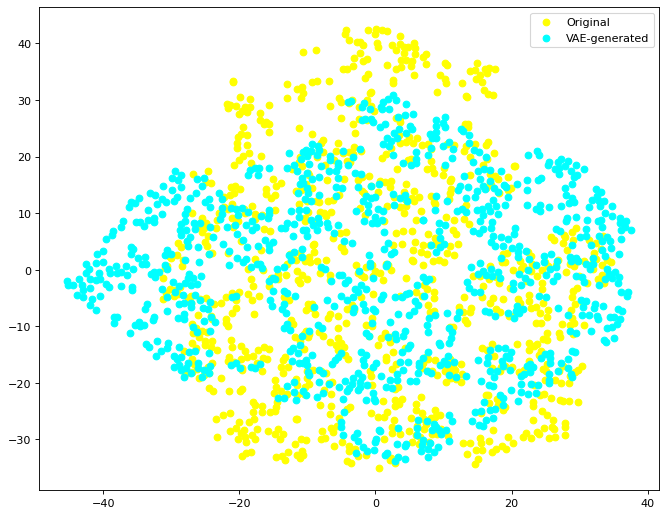

In [47]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(X_main_2D[:900, 0], X_main_2D[:900, 1], c=['yellow'], label='Original')
plt.scatter(X_vae_2D[:900, 0], X_vae_2D[:900, 1], c=['cyan'], label='VAE-generated')
plt.legend()
plt.show()

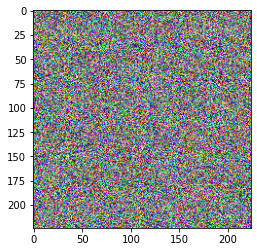

In [14]:
def create_random_image():
  return np.random.rand(224, 224, 3)


plt.imshow(create_random_image())
plt.show()

In [15]:
count = 450
rand_data = [create_random_image() for i in range(0, 2*count)]
print(len(rand_data))

X_rand = np.array(rand_data)

900


In [16]:
rand_enc, rand_dec = encoder(), decoder()
rand_ae = keras.models.Sequential([rand_enc, rand_dec])
rand_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=[rounded_accuracy])

rand_ae.fit(X_rand, X_rand, epochs=2, validation_split=0.2, batch_size=64)

Epoch 1/2
12/12 [==============================] - 7s 369ms/step - loss: 2.2938 - rounded_accuracy: 0.5000 - val_loss: 1.5867 - val_rounded_accuracy: 0.5001
Epoch 2/2
12/12 [==============================] - 3s 215ms/step - loss: 1.3991 - rounded_accuracy: 0.5000 - val_loss: 1.3524 - val_rounded_accuracy: 0.4999


1/1 [==============================] - 1s 550ms/step


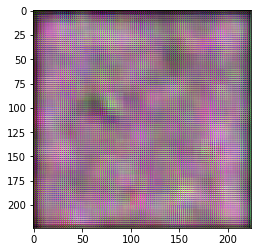

In [18]:
plt.imshow(rand_ae.predict(X_rand[:1])[0])
plt.show()

In [19]:
X_rand_compressed = rand_enc.predict(X_rand)
X_rand_2D = tsne.fit_transform(X_rand_compressed)
X_rand_2D.shape

29/29 [==============================] - 1s 22ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(900, 2)

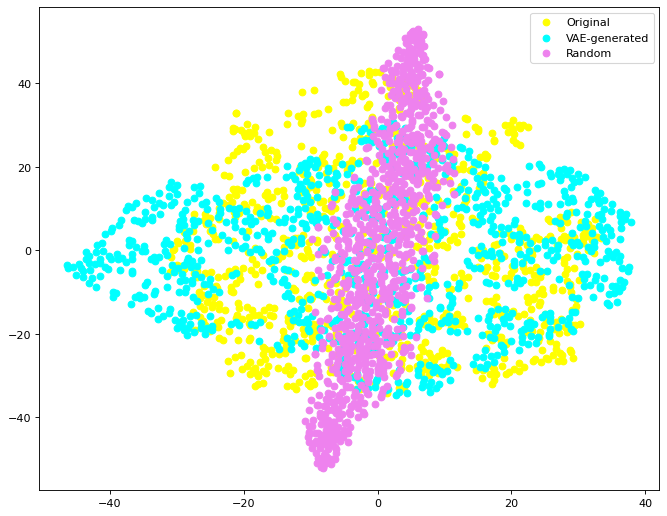

In [20]:
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(X_main_2D[:900, 0], X_main_2D[:900, 1], c=['yellow'], label='Original')
plt.scatter(X_vae_2D[:900, 0], X_vae_2D[:900, 1], c=['cyan'], label='VAE-generated')
plt.scatter(X_rand_2D[:900, 0], X_rand_2D[:900, 1], c=['violet'], label='Random')
plt.legend()
plt.show()